# Marks Molecule Calculations Code

# Startup

## Imports

In [1]:
import sys
sys.path.append("..")
import numpy as np
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.quantum.cg import CG
import matplotlib.font_manager
import pandas as pd
import math
import scipy.linalg
import IPython.display
import matplotlib.pyplot as plt
import Analysis_Python_Files.Constants as mc
import Analysis_Python_Files.Miscellaneous as misc
import matplotlib.style
import matplotlib as mpl
import copy
matplotlib.style.use('default')
pd.set_option("max_colwidth", 200)
from importlib import reload

In [2]:
import time

The important import!

In [3]:
import Analysis_Python_Files.MoleculeCalculation_Mark_orig as mol
import Analysis_Python_Files.CollisionalAnalysis as lac

## Constants

In [4]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
transFreq =mc.Rb87_D1LineFrequency
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
lifetime = mc.Rb87_D1_Lifetime
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(mc.Rb87_D1LineFrequency)
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

377107463500000.0
4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  1.434578675587725e-45 but this differs from the literature value which is:  5.94492796981645e-48


A = 2/V**(3/2)

# Calculations

## Create the relevant bases

### Create Atomic Bases

these are the ordinary single-atom bases that you'd use to describe your atom if you didn't know anything about the molecular symmetries.

In [19]:
ival = 0
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [ival])
lsiToJi_Op = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
jiToF_Op = mol.create_jiToF_Op(jiBasis, fBasis)

lsi2ToJi2_Op = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
# ji2ToF2_Op = mol.create_(jiBasis, fBasis)

caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [ival], I_BOvals=['g', 'u'])
caseASymHfs = mol.createCaseABasis_Sym([1],[0,1],[ival], I_BOvals=['g','u'])

In [21]:
expandedBOBasis = mol.addFsRelevantStates(mol.boStates)
caseASymHfs = mol.addHfsRelevantStates(expandedBOBasis,i_val = ival)

note that as the two particle bases are kronicker-products of the one-particle basis, they include doubly-excited atoms with $L_a = L_b = 1$

In [7]:
structureList = [lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom, caseAMostlySymHfs, caseASymHfs, lsiToJi_Op, jiToF_Op]

basisDesc = pd.DataFrame()
basisDesc["Size"] = [np.array(base).shape for base in structureList]
basisDesc["Keys"] = [str([r"$"+key + "$" for key in base[0].keys()]) for base in structureList[:-2]] + ["N/A", "N/A"]
basisDesc["Example Value"] = [base[0] for base in structureList]
basisDesc.index = ["lsiBasis", "jiBasis", "fBasis", "lsiBasis2Atom", "jiBasis2Atom", "fBasis2Atom", "caseAMostlySymHfs", "caseASymHfs", "lsiToJi_Op", "jiToF_Op"]
display(basisDesc)

,Size,Keys,Example Value
lsiBasis,"(32,)","['$l_x$', '$m_l_x$', '$s_x$', '$m_s_x$', '$i_x$', '$m_i_x$']","{'l_x': 0, 'm_l_x': 0, 's_x': 0.5, 'm_s_x': -0.5, 'i_x': 1.5, 'm_i_x': -1.5}"
jiBasis,"(32,)","['$j_x$', '$m_j_x$', '$l_x$', '$s_x$', '$i_x$', '$m_i_x$']","{'j_x': 0.5, 'm_j_x': -0.5, 'l_x': 0, 's_x': 0.5, 'i_x': 1.5, 'm_i_x': -1.5}"
fBasis,"(32,)","['$f_x$', '$m_f_x$', '$j_x$', '$l_x$', '$s_x$', '$i_x$']","{'f_x': 1.0, 'm_f_x': -1.0, 'j_x': 0.5, 'l_x': 0, 's_x': 0.5, 'i_x': 1.5}"
lsiBasis2Atom,"(1024,)","['$l_a$', '$m_l_a$', '$s_a$', '$m_s_a$', '$i_a$', '$m_i_a$', '$l_b$', '$m_l_b$', '$s_b$', '$m_s_b$', '$i_b$', '$m_i_b$']","{'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'i_a': 1.5, 'm_i_a': -1.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': -0.5, 'i_b': 1.5, 'm_i_b': -1.5}"
jiBasis2Atom,"(1024,)","['$j_a$', '$m_j_a$', '$l_a$', '$s_a$', '$i_a$', '$m_i_a$', '$j_b$', '$m_j_b$', '$l_b$', '$s_b$', '$i_b$', '$m_i_b$']","{'j_a': 0.5, 'm_j_a': -0.5, 'l_a': 0, 's_a': 0.5, 'i_a': 1.5, 'm_i_a': -1.5, 'j_b': 0.5, 'm_j_b': -0.5, 'l_b': 0, 's_b': 0.5, 'i_b': 1.5, 'm_i_b': -1.5}"
fBasis2Atom,"(1024,)","['$f_a$', '$m_f_a$', '$j_a$', '$l_a$', '$s_a$', '$i_a$', '$f_b$', '$m_f_b$', '$j_b$', '$l_b$', '$s_b$', '$i_b$']","{'f_a': 1.0, 'm_f_a': -1.0, 'j_a': 0.5, 'l_a': 0, 's_a': 0.5, 'i_a': 1.5, 'f_b': 1.0, 'm_f_b': -1.0, 'j_b': 0.5, 'l_b': 0, 's_b': 0.5, 'i_b': 1.5}"
caseAMostlySymHfs,"(384,)","['$L$', '$Lambda$', '$I_BO$', '$S$', '$Sigma$', '$I$', '$Iota$', '$i_a$', '$i_b$', '$Omega$', '$Phi$']","{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 'I': 0.0, 'Iota': -0.0, 'i_a': 1.5, 'i_b': 1.5, 'Omega': 0, 'Phi': 0.0}"
caseASymHfs,"(230,)","['$L$', '$|Lambda|$', '$S$', '$I_BO$', '$kappa_BO$', '$|Sigma|$', '$kappa_FS$', '$|Omega|$', '$|Phi|$', '$I$', '$|Iota|$', '$i_a$', '$i_b$', '$kappa_HFS$']","{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Phi|': 0.0, 'I': 0.0, '|Iota|': 0.0, 'i_a': 1.5, 'i_b': 1.5, 'kappa_HFS': 1.0}"
lsiToJi_Op,"(32, 32)",N/A,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
jiToF_Op,"(32, 32)",N/A,"[0.0, -0.5, 0.0, 0.0, 0.8660254037844386, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### Create $\phi = 0$ Bases

I need to sort the states in the complete basis "caseASymHfs" by their symmetry label so that I can calculate the different symmetries separately and label them appropriately at the end.

In [22]:
phi=0
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for totalSpatialParity in totalSpatialParityIncluded:
    totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
    for state in caseASymHfs:
        I_BOval = mol.g if state['I_BO'] == 'g' else mol.u
        if math.isclose(abs(state['|Phi|']),phi):
            if (-1)**(state['I']+I_BOval) == totalSpatialParityVal:
                kappa_HFS_ParityStr = '1' if state['kappa_HFS'] == 1 else '2'
                symmetryLabel = str(phi) + totalSpatialParity + kappa_HFS_ParityStr
                if symmetryLabel not in symmetrizedBases:
                    symmetrizedBases[symmetryLabel] = []
                symmetrizedBases[symmetryLabel].append(state)

### Create $\phi = 1$ through $5$ Bases

In [23]:
phiIncluded=np.arange(1,6)
totalSpatialParityIncluded = ['a','b']
mostlySymmetrizedBases = {}
for phi in phiIncluded:
    for totalSpatialParity in totalSpatialParityIncluded:
        totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
        for state in caseAMostlySymHfs:
            I_BOval = mol.g if state['I_BO'] == 'g' else mol.u
            if math.isclose(abs(state['Phi']),phi):
                if (-1)**(state['I']+I_BOval) == totalSpatialParityVal:
                    label = str(phi) + totalSpatialParity
                    if label not in mostlySymmetrizedBases:
                        mostlySymmetrizedBases[label] = []
                    mostlySymmetrizedBases[label].append(state)

## Fine Structure and Hyperfine Structure Hamiltonians

### Create FS and HFS Hamiltonians for the Atomic Bases

In [24]:
fsH = mol.create_H_FS(jiBasis2Atom)* 2 * E_FS_5P12_5P32 / 3
hfsH = mol.create_H_HFS(fBasis2Atom, E_HFS_5P12_F1F2, E_HFS_5S12_F1F2, mc.Rb87_5P32_ToF3, mc.Rb87_5P32_ToF2, mc.Rb87_5P32_ToF1, mc.Rb87_5P32_ToF0) * mc.h

In [25]:
allFsEigvals, _ = np.linalg.eigh(fsH)
fsEigvals = np.array(list(set(allFsEigvals)))
print("Fine-Structure Hamiltonian Eigen-Energies (GHz): ", fsEigvals/(mc.h*1e9))
allHfsEigvals, _ = np.linalg.eigh(hfsH)
hfsEigvals = np.array(list(set(allHfsEigvals)))
print("Hyper-Fine-Structure Hamiltonian Eigen-Energies (GHz): ", hfsEigvals/(mc.h*1e9))

Fine-Structure Hamiltonian Eigen-Energies (GHz):  [-9497.361     0.    -2374.34  -4748.681  4748.681  2374.34 ]
Hyper-Fine-Structure Hamiltonian Eigen-Energies (GHz):  [ 0.    -0.604 -0.302]


Why are there six eigenvalues of the fine structure hamiltonian? There are only two fine structure manifolds we are actually considering, $5S_{1/2}+5P_{1/2}$ and $5S_{1/2} + 5P_{3/2}$, but the basis itself includes double-ground state and double excited states, so we also see $5S_{1/2}+5S_{1/2},5P_{1/2}+5P_{1/2}, 5P_{1/2}+5P_{3/2},$ and $ 5P_{3/2}+5P_{3/2}$ energies. There is a similar problem with the hyper-fine structure hamiltonian, where we are only going to work with a limited number of the above energies. If we look at the difference between a certain two of these eigenvalues though...

In [13]:
print("From Matrix Eigenvalues (GHz):", (fsEigvals[2]-fsEigvals[0])/(mc.h*1e9))
print("Literature Value (GHz):", mc.Rb87_D2LineFrequency/1e9-mc.Rb87_D1LineFrequency/1e9)

From Matrix Eigenvalues (GHz): 7123.0209685
Literature Value (GHz): 7123.020968500001


we can see that the excited state fine-structure splitting is recovered.

### Create FS and HFS Hamiltonians for each molecular symmetry label

#### $\Phi=0$

In [26]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            I_BO = mol.g if caseAState["I_BO"] == "g" else mol.u
            nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symHfsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op )
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=lsiToJi_Op )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
        hfsStates.append(symHfsState / np.sqrt(len(indexes)))
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

Working on states of symmetry 0b2. 2 states


#### debugging (ignore for now)

In [15]:
caseAToLsi_ = mol.genCaseAToLsiTransform2(symmetrizedBases['0b1'], lsiBasis2Atom, caseAMostlySymHfs).T

[56, 59] [1, -1]
[58, 61] [1, -1]
[12] [1]
[14] [1]
[63, 66] [1, 1]
[1] [1]
[3] [1]
[21, 17] [1, -1]
[23, 19] [1, -1]
[35, 41] [1, -1]
[37, 43] [1, -1]
[69, 71] [1, -1]
[28, 24] [1, 1]
[30, 26] [1, 1]
[48, 54] [1, 1]
[72, 74] [1, 1]
[32, 38] [1, 1]
[34, 40] [1, 1]
[45, 51] [1, -1]


In [16]:
caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T

[56, 59] [1, -1]
[58, 61] [1, -1]
[12] [1]
[14] [1]
[63, 66] [1, 1]
[1] [1]
[3] [1]
[21, 17] [1, -1]
[23, 19] [1, -1]
[35, 41] [1, -1]
[37, 43] [1, -1]
[69, 71] [1, -1]
[28, 24] [1, 1]
[30, 26] [1, 1]
[48, 54] [1, 1]
[72, 74] [1, 1]
[32, 38] [1, 1]
[34, 40] [1, 1]
[45, 51] [1, -1]


In [18]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            I_BO = mol.g if caseAState["I_BO"] == "g" else mol.u
            nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symHfsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op )
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=lsiToJi_Op )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
        hfsStates.append(symHfsState / np.sqrt(len(indexes)))
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    #H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)
    
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    caseAToJi =  lsi2ToJi2_Op @ caseAToLsi
    H_fs_phi[label] = caseAToJi.T @ fsH @ caseAToJi + np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

Working on states of symmetry 0b1. 19 states
starting genCaseAToLsiTransform2
starting caseAMostlySymToLsi_2Transf
[56, 59] [1, -1]          
(384, 1024) (384, 1)
[58, 61] [1, -1]          
(384, 1024) (384, 1)
[12] [1]                  
(384, 1024) (384, 1)
[14] [1]                  
(384, 1024) (384, 1)
[63, 66] [1, 1]           
(384, 1024) (384, 1)
[1] [1]                   
(384, 1024) (384, 1)
[3] [1]                   
(384, 1024) (384, 1)
[21, 17] [1, -1]          
(384, 1024) (384, 1)
(384, 1024) (384, 1)
[23, 19] [1, -1]          
(384, 1024) (384, 1)
(384, 1024) (384, 1)
[35, 41] [1, -1]          
(384, 1024) (384, 1)
[37, 43] [1, -1]          
(384, 1024) (384, 1)
[69, 71] [1, -1]          
(384, 1024) (384, 1)
[28, 24] [1, 1]           
(384, 1024) (384, 1)
(384, 1024) (384, 1)
[30, 26] [1, 1]           
(384, 1024) (384, 1)
(384, 1024) (384, 1)
[48, 54] [1, 1]           
(384, 1024) (384, 1)
[72, 74] [1, 1]           
(384, 1024) (384, 1)
[32, 38] [1, 1]           
(384, 

### end debugging

#### $\Phi=1-5$

The loop for 1-5 is slightly different since these states have one less symmetry.

So if you write down the case-A states as $|L Lambda sigma S Sigma I Iota i_a i_b Omega phi$ then you can classify them as phi i kappa, and then I convert fs and hfs states into this base. that's what I'm doing more or less

In [27]:
for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [[], []]
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        I_BO = mol.g if state["I_BO"] == "g" else mol.u
        nuclearNums = [state['I'], state['Iota'],state['i_a'],state['i_b'],]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        fsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=lsiToJi_Op ));
        hfsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op ))
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset=-1/2 * 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

Working on states of symmetry 2b. 2 states


## Diagonalize the total energy at all distances.

for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [[], []]
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        I_BO = mol.g if state["I_BO"] == "g" else mol.u
        nuclearNums = [state['I'], state['Iota'],state['i_a'],state['i_b'],]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        fsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=lsiToJi_Op ));
        hfsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op ))
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset=-1/2 * 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

In [19]:
symmetrizedBases.keys()

dict_keys(['0a1', '0a2', '0b2', '0b1'])

In [20]:
mostlySymmetrizedBases.keys()

dict_keys(['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b'])

In [28]:
allBases = {**symmetrizedBases, **mostlySymmetrizedBases}
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )
energies = {}
for label, base in allBases.items():
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label, '\nCalcualting Eigenvalues at every R')
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        totalEnergy = mol.get_H_BO(C_3_val, rv, base).astype(float) + H_fs_phi[label] + H_hfs_phi[label]
        eigVals, eigVectors = np.linalg.eigh(totalEnergy)
        energies[label][num] = eigVals


Label: 2b 
Calcualting Eigenvalues at every R


### misc

In [14]:
def getLabelColorAndLinestyle(label):
    phiColors=['purple', 'blue', 'cyan', 'green', 'y', 'red']       
    if label[0] == '0':
        if label[-1] == '1':
            color = 'black'
        elif label[-1] == '2':
            color = '#800080'
    else:
        color = phiColors[int(label[0])]
    linestyle = '-.' if label[1] == 'a' else '-'
    return color, linestyle

In [22]:
for key in H_fs_phi.keys():
    H_fs = H_fs_phi[key]
    H_hfs = H_hfs_phi[key]
    vals, vecs = np.linalg.eig(H_fs+H_hfs)
    v = np.real(vals)/mc.h/1e12
    print(key, H_fs.shape, H_hfs.shape, '\n', set(np.round(v*1e6)/1e6))
    print()

0a1 (19, 19) (19, 19) 
 {-0.001, -0.003193, -7.1237, -7.121707, -7.123924, -7.124054, 0.002557, -0.001026, -0.004279, 0.002298, -0.000866, -0.003146, 0.002375, -7.121544, -0.000679, -0.003343, -7.121509, 0.00284, -7.12404}

0a2 (19, 19) (19, 19) 
 {-0.000861, 0.002579, -0.003284, -7.124123, -7.121448, -7.121616, -7.121598, -7.123776, 0.0022, -0.000964, 0.002408, -0.003061, -0.004366, -0.001094, -7.123906, -0.000764, -0.003013, 0.002757, -7.124012}

0b2 (19, 19) (19, 19) 
 {-0.000861, 0.002579, -0.003284, -7.123776, -7.121616, -7.121448, -7.124123, -7.121598, 0.0022, -0.000964, 0.002408, -0.003061, -0.004366, -0.001094, -7.123906, -0.000764, -0.003013, 0.002757, -7.124012}

0b1 (19, 19) (19, 19) 
 {-0.001, -0.003193, -7.1237, -7.121707, -7.123924, -7.124054, 0.002557, -0.001026, -0.004279, -0.000866, 0.002298, -0.003146, 0.002375, -7.121544, -0.000679, -0.003343, -7.121509, 0.00284, -7.12404}

1a (68, 68) (68, 68) 
 {0.002261, 0.002333, -0.004345, -7.120152, 0.002757, -0.004502, 0.00249

def fsReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    names = ['L', 'mL', 'S', 'mS', 'I', 'mI']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I','mI']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val
    return op

def hfsReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS', 'mI']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val                        
    return op

# Displaying The Results

## Matplotlib Plotting

### single picture

In [23]:
def getLabelColorAndLinestyle(label):
    phiColors=['purple','blue','green', 'orange','red', '#FF69B4']       
    if label[0] == '0':
        if label[-1] == '1':
            color = 'black'
        elif label[-1] == '2':
            color = '#800080'
    else:
        color = phiColors[int(label[0])]
    linestyle = 'dashed' if label[1] == 'b' else 'solid'
    return color, linestyle

In [52]:
# def getLabelColorAndLinestyle(label):
#     phicol = 'black'
#     phiColors=[phicol,phicol,phicol,phicol,phicol,phicol]       
#     if label[0] == '0':
#         if label[-1] == '1':
#             color = 'black'
#         elif label[-1] == '2':
#             color = 'black'
#     else:
#         color = phiColors[int(label[0])]
#     linestyle = 'dashed' if label[1] == 'b' else 'solid'
#     return color, linestyle

In [25]:
for base in H_hfs_phi.values():
    vals, vecs = np.linalg.eig(base)
    v = np.real(vals)/mc.h/1e12
    print(set(np.round(v*1e6)/1e6))

{0.002261, 0.002333, -0.004345, 0.002053, 0.002869, 0.002757, -0.004502, 0.00249, -0.004782, -0.003965, -0.004078}
{0.002053, 0.002333, -0.004345, 0.002869, 0.002757, -0.004502, 0.00249, -0.004782, -0.004574, -0.003965, -0.004078}
{0.002053, 0.002333, -0.004345, 0.002869, 0.002757, -0.004502, 0.00249, -0.004574, -0.004782, -0.003965, -0.004078}
{0.002053, 0.002261, -0.004345, 0.002869, 0.002757, -0.004502, 0.00249, -0.004782, -0.003965, 0.002333, -0.004078}
{0.002261, 0.002053, -0.004345, 0.002333, 0.002869, 0.002757, -0.004502, 0.00249, -0.004574, -0.004782, -0.003965, -0.004078}
{0.002261, 0.002053, -0.004345, 0.002333, 0.002869, 0.002757, -0.004502, 0.00249, -0.004574, -0.004782, -0.003965, -0.004078}
{0.002053, 0.002261, -0.004345, 0.002333, 0.002869, 0.002757, -0.004502, 0.00249, -0.004782, -0.003965, -0.004078}
{0.002261, 0.002053, -0.004345, 0.002333, 0.002869, 0.002757, -0.004502, 0.00249, -0.004782, -0.003965, -0.004078}
{0.002053, -0.004345, 0.002869, 0.002757, 0.00249, -0.00

In [26]:
for base in H_fs_phi.values():
    vals, vecs = np.linalg.eig(base)
    v = np.real(vals)/mc.h/1e12
    print(set(np.round(v*1e6)/1e6))

{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{0.0, -7.123021}
{-0.0}
{-0.0}


In [27]:
for label in H_fs_phi.keys():
    H_ = H_fs_phi[label] + H_hfs_phi[label]
    vals, vecs = np.linalg.eig(H_)
    v = np.real(vals)/mc.h/1e12
    print(set(np.round(v*1e6)/1e6))

{-0.001, -0.003193, -7.1237, -7.121707, -7.123924, -7.124054, 0.002557, -0.001026, -0.004279, 0.002298, -0.000866, -0.003146, 0.002375, -7.121544, -0.000679, -0.003343, -7.121509, 0.00284, -7.12404}
{-0.000861, 0.002579, -0.003284, -7.124123, -7.121448, -7.121616, -7.121598, -7.123776, 0.0022, -0.000964, 0.002408, -0.003061, -0.004366, -0.001094, -7.123906, -0.000764, -0.003013, 0.002757, -7.124012}
{-0.000861, 0.002579, -0.003284, -7.123776, -7.121616, -7.121448, -7.124123, -7.121598, 0.0022, -0.000964, 0.002408, -0.003061, -0.004366, -0.001094, -7.123906, -0.000764, -0.003013, 0.002757, -7.124012}
{-0.001, -0.003193, -7.1237, -7.121707, -7.123924, -7.124054, 0.002557, -0.001026, -0.004279, -0.000866, 0.002298, -0.003146, 0.002375, -7.121544, -0.000679, -0.003343, -7.121509, 0.00284, -7.12404}
{0.002261, 0.002333, -0.004345, -7.120152, 0.002757, -0.004502, 0.00249, -0.004574, -7.126986, -7.120968, -0.004078, -7.127803}
{0.002261, 0.002333, -0.004345, 0.002757, -0.004502, 0.00249, -0.0

## FS

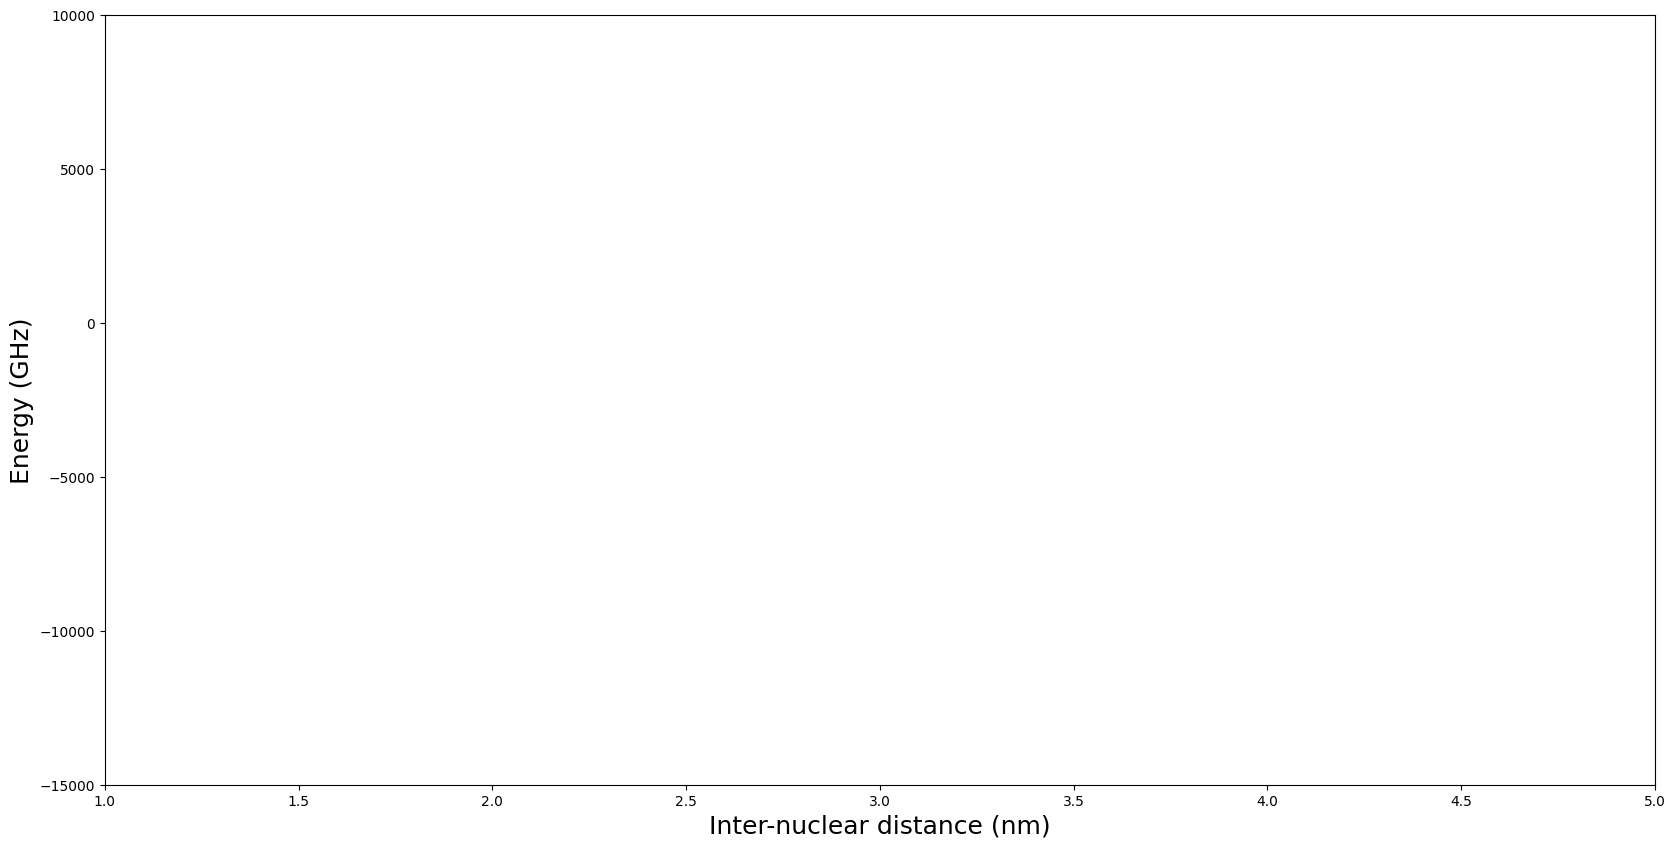

In [72]:
Rval = Rvals
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val = mc.Rb87_C3

def Extract1(e1):
    return [item[0] for item in e1]

def Extract2(e2):
    return [item[1] for item in e2]

def Extract3(e3):
    return [item[2] for item in e3]

# 0+g
Htot1 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot1.append(w*1e-9/mc.h)

Htot1_list = list(map(list,Htot1))
H1_e1 = Extract1(Htot1_list)
H1_e2 = Extract2(Htot1_list)

# 0+u
Htot2 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3, np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h)
    
Htot2_list = list(map(list,Htot2))
H2_e1 = Extract1(Htot2_list)
H2_e2 = Extract2(Htot2_list)

# 0-g
Htot3 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot3.append(w*1e-9/mc.h);
    
Htot3_list = list(map(list,Htot3))
H3_e1 = Extract1(Htot3_list)
H3_e2 = Extract2(Htot3_list)
# print(H1_e2)
# print(DeltaVal)

# 0-u
Htot4 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, -np.sqrt(2)*DeltaVal/3, -np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot4.append(w*1e-9/mc.h)
    
Htot4_list = list(map(list,Htot4))
H4_e1 = Extract1(Htot4_list)
H4_e2 = Extract2(Htot4_list)




# 1g    
Htot5 = []
for a in Rval:
    H = [[C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3], [-DeltaVal/3, -C_3_val/a**3 - DeltaVal/3, DeltaVal/3],\
         [DeltaVal/3, DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot5.append(w*1e-9/mc.h)
    
Htot5_list = list(map(list,Htot5))
H5_e1 = Extract1(Htot5_list)
H5_e2 = Extract2(Htot5_list)
H5_e3 = Extract3(Htot5_list)

# 1u    
Htot6 = []
for a in Rval:
    H = [-C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3, -DeltaVal/3, C_3_val/a**3 - DeltaVal/3, DeltaVal/3,\
         DeltaVal/3, DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot6.append(w*1e-9/mc.h)
    
Htot6_list = list(map(list,Htot6))
H6_e1 = Extract1(Htot6_list)
H6_e2 = Extract2(Htot6_list)   
H6_e3 = Extract3(Htot6_list)

#2g    
Htot7 = []
for a in Rval:
    H = C_3_val/a**3
    Htot7.append(H*1e-9/mc.h)

# 2u    
Htot8 = []
for a in Rval:
    H = -C_3_val/a**3
    Htot8.append(H*1e-9/mc.h)
 
# line at zero
Htot9 = []
for a in Rval:
    H = 0
    Htot9.append(H*1e-9/mc.h)

# line below zero
Htot10 = []
for a in Rval:
    H = -7100
    Htot10.append(H)    
    
plt.figure(figsize=(20,10)) 
plt.xlabel("Inter-nuclear distance (nm)",fontsize=18)
plt.ylabel("Energy (GHz)",fontsize=18);
plt.ylim(-15000,10000)
plt.xlim(1,5)
# ax.set_ylim(*ylims)
# ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)


import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

# mpl.rc('font', **font)
# plt.plot(Rval*1e9,H1_e1,color = 'mediumblue',linestyle = ':',label = r'$0_g^+$') ### 0^g- in Marks calc
# plt.plot(Rval*1e9,H1_e2, color = 'mediumblue',linestyle = ':')                   ### 0^g- in Marks calc
# plt.plot(Rval*1e9,H2_e1,color = 'mediumblue', label = r'$0_u^+$')
# plt.plot(Rval*1e9,H2_e2,color = 'mediumblue')
# plt.plot(Rval*1e9,H3_e1,color = 'teal',linestyle = '-.', label = r'$0_g^-$') ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H3_e2,color = 'teal',linestyle = '-.')                     ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H4_e1,color = 'mediumturquoise',linestyle = ':', label = r'$0_u^-$')
# plt.plot(Rval*1e9,H4_e2,color = 'mediumturquoise',linestyle = ':')
# plt.plot(Rval*1e9,H5_e1,color = 'mediumseagreen', label = r'$1_g$')
# plt.plot(Rval*1e9,H5_e2,color = 'mediumseagreen')
# plt.plot(Rval*1e9,H5_e3,color = 'mediumseagreen')
# plt.plot(Rval*1e9,H6_e1,color = 'limegreen', linestyle = '-.', label = r'$1_u$')
# plt.plot(Rval*1e9,H6_e2,color = 'limegreen', linestyle = '-.')
# plt.plot(Rval*1e9,H6_e3,color = 'limegreen', linestyle = '-.')
# plt.plot(Rval*1e9,Htot7,color =  'yellow', linestyle = ':',label = r'$2_g$')
# plt.plot(Rval*1e9,Htot8,color = 'yellow', label = r'$2_u$')
# plt.plot(Rval*1e9,Htot9,color = 'lightpink', label = 'F states')
# plt.plot(Rval*1e9,Htot10,color = 'lightpink')
# plt.legend(loc='upper center', mode = "expand", ncol = 8)
# # plt.margins(x=0)
# # from matplotlib.pyplot import figure
# # fig.savefig('FS.png', dpi=100)


### HFS and FS

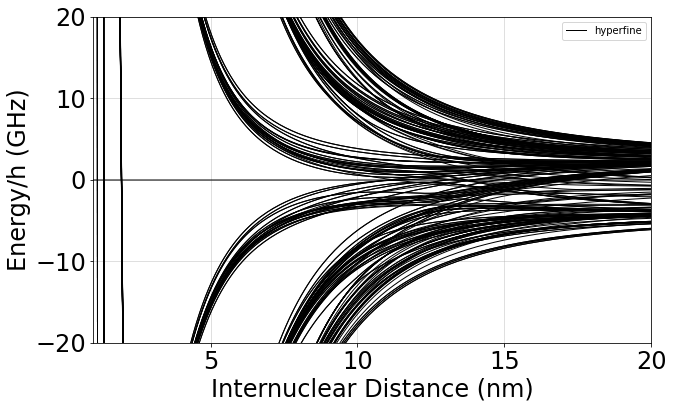

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
fs = 24

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,    -mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b','3a','3b','4a','4b','5a','5b']
# for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
which = 0
title, ylims, yoff = titles[which], allYlims[which], yoffsets[which]
for label in labels:
    color, linestyle = getLabelColorAndLinestyle(label)
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color='black', linestyle='-', linewidth=1, 
                label='hyperfine' if datanum==0 and label=='2b' else None)
leg = ax.legend(fontsize=12, ncol=7, loc='upper center', bbox_to_anchor=(0.5,1.15))
for text in leg.get_texts():
    text.set_color("k")

ax.tick_params(axis='both', which='major', labelsize=fs)

ax.axhline(0,color='k',alpha=0.5)
# ax.text(60,-1.4, title + "\nDissociation Limit", fontsize=fs, color='k')
# ax.set_ylim(*ylims)
# ax.set_xlim(min(Rvals)*1e9,40)
plt.xlim(1,20)
plt.ylim(-20,20)
ax.grid(alpha=0.5)
#if num != len(axs)-1 and num != len(axs)-2 and num != 0:
#    ax.set_xticklabels([]);
#elif num != 0:
ax.set_xlabel('Internuclear Distance (nm)', fontsize=fs)
ax.set_ylabel('Energy/h (GHz)', fontsize=fs)

# plt.plot(Rval*1e9,H1_e1,color = 'limegreen',label = 'fine') ### 0^g- in Marks calc
# plt.plot(Rval*1e9,H1_e2, color = 'limegreen')                   ### 0^g- in Marks calc
# plt.plot(Rval*1e9,H2_e1,color = 'limegreen')
# plt.plot(Rval*1e9,H2_e2,color = 'limegreen')
# plt.plot(Rval*1e9,H3_e1,color = 'limegreen') ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H3_e2,color = 'limegreen')                     ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H4_e1,color = 'limegreen')
# plt.plot(Rval*1e9,H4_e2,color = 'limegreen')
# plt.plot(Rval*1e9,H5_e1,color = 'limegreen')
# plt.plot(Rval*1e9,H5_e2,color = 'limegreen')
# plt.plot(Rval*1e9,H5_e3,color = 'limegreen')
# plt.plot(Rval*1e9,H6_e1,color = 'limegreen')
# plt.plot(Rval*1e9,H6_e2,color = 'limegreen')
# plt.plot(Rval*1e9,H6_e3,color = 'limegreen')
# plt.plot(Rval*1e9,Htot7,color =  'limegreen')
# plt.plot(Rval*1e9,Htot8,color = 'limegreen')
# # plt.plot(Rval*1e9,Htot9,color = 'limegreen', label = 'F states')
# plt.plot(Rval*1e9,Htot10,color = 'limegreen')


plt.legend(loc='upper right')
# plt.margins(x=0)
# from matplotlib.pyplot import figure
# fig.savefig('FS.png', dpi=100)


#plt.savefig("D1_Zoomed_Out.svg", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

### HFS and FS shifted

In [210]:
Rval = np.linspace( 20*mc.a0, 100*50*mc.a0, 100 )
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val = mc.Rb87_C3
offset = 0 #2.73

def Extract1(e1):
    return [item[0] for item in e1]

def Extract2(e2):
    return [item[1] for item in e2]

def Extract3(e3):
    return [item[2] for item in e3]

# 0+g
Htot1 = []
for a in Rval:
    H = [2*C_3_val/a**3 - DeltaVal/3, -np.sqrt(2)*DeltaVal/3,-np.sqrt(2)*DeltaVal/3,C_3_val/a**3 - 2*DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot1.append(w*1e-9/mc.h)

Htot1_list = list(map(list,Htot1))
H1_e1 = Extract1(Htot1_list)
H1_e2 = Extract2(Htot1_list)
H1_e1 = [x + offset for x in H1_e1]
H1_e2 = [x + offset for x in H1_e2]

# 0+u
Htot2 = []
for a in Rval:
    H = [-2*C_3_val/a**3 - DeltaVal/3, -np.sqrt(2)*DeltaVal/3, -np.sqrt(2)*DeltaVal/3,-C_3_val/a**3 - 2*DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h)
    
Htot2_list = list(map(list,Htot2))
H2_e1 = Extract1(Htot2_list)
H2_e2 = Extract2(Htot2_list)
H2_e1 = [x + offset for x in H2_e1]
H2_e2 = [x + offset for x in H2_e2]

# 0-g
Htot3 = []
for a in Rval:
    H = [-2*C_3_val/a**3 - DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,C_3_val/a**3 - 2*DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot3.append(w*1e-9/mc.h);
    
Htot3_list = list(map(list,Htot3))
H3_e1 = Extract1(Htot3_list)
H3_e2 = Extract2(Htot3_list)
H3_e1 = [x + offset for x in H3_e1]
H3_e2 = [x + offset for x in H3_e2]

# print(H1_e2)
# print(DeltaVal)

# 0-u
Htot4 = []
for a in Rval:
    H = [2*C_3_val/a**3 - DeltaVal/3, np.sqrt(2)*DeltaVal/3, np.sqrt(2)*DeltaVal/3,-C_3_val/a**3 - 2*DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot4.append(w*1e-9/mc.h)
    
Htot4_list = list(map(list,Htot4))
H4_e1 = Extract1(Htot4_list)
H4_e2 = Extract2(Htot4_list)
H4_e1 = [x + offset for x in H4_e1]
H4_e2 = [x + offset for x in H4_e2]



# 1g    
Htot5 = []
for a in Rval:
    H = [[-2*C_3_val/a**3 - DeltaVal/3, DeltaVal/3, DeltaVal/3], [DeltaVal/3, -C_3_val/a**3 - DeltaVal/3, -DeltaVal/3],\
         [DeltaVal/3, -DeltaVal/3,C_3_val/a**3 - DeltaVal/3]]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot5.append(w*1e-9/mc.h)
    
Htot5_list = list(map(list,Htot5))
H5_e1 = Extract1(Htot5_list)
H5_e2 = Extract2(Htot5_list)
H5_e3 = Extract3(Htot5_list)
H5_e1 = [x + offset for x in H5_e1]
H5_e2 = [x + offset for x in H5_e2]
H5_e3 = [x + offset for x in H5_e3]

# 1u    
Htot6 = []
for a in Rval:
    H = [2*C_3_val/a**3 - DeltaVal/3, DeltaVal/3, DeltaVal/3, DeltaVal/3, C_3_val/a**3 - DeltaVal/3, -DeltaVal/3,\
         DeltaVal/3, -DeltaVal/3,C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot6.append(w*1e-9/mc.h)
    
Htot6_list = list(map(list,Htot6))
H6_e1 = Extract1(Htot6_list)
H6_e2 = Extract2(Htot6_list)   
H6_e3 = Extract3(Htot6_list)
H6_e1 = [x + offset for x in H6_e1]
H6_e2 = [x + offset for x in H6_e2]
H6_e3 = [x + offset for x in H6_e3]

#2g    
Htot7 = []
for a in Rval:
    H = C_3_val/a**3
    Htot7.append(H*1e-9/mc.h + offset)

# 2u    
Htot8 = []
for a in Rval:
    H = -C_3_val/a**3
    Htot8.append(H*1e-9/mc.h + offset)


# line at zero
Htot9 = []
for a in Rval:
    H = 0
    Htot9.append(H*1e-9/mc.h)

# line below zero
Htot10 = []
for a in Rval:
    H = -7100
    Htot10.append(H)    

Text(0, 0.5, 'Energy/h (GHz)')

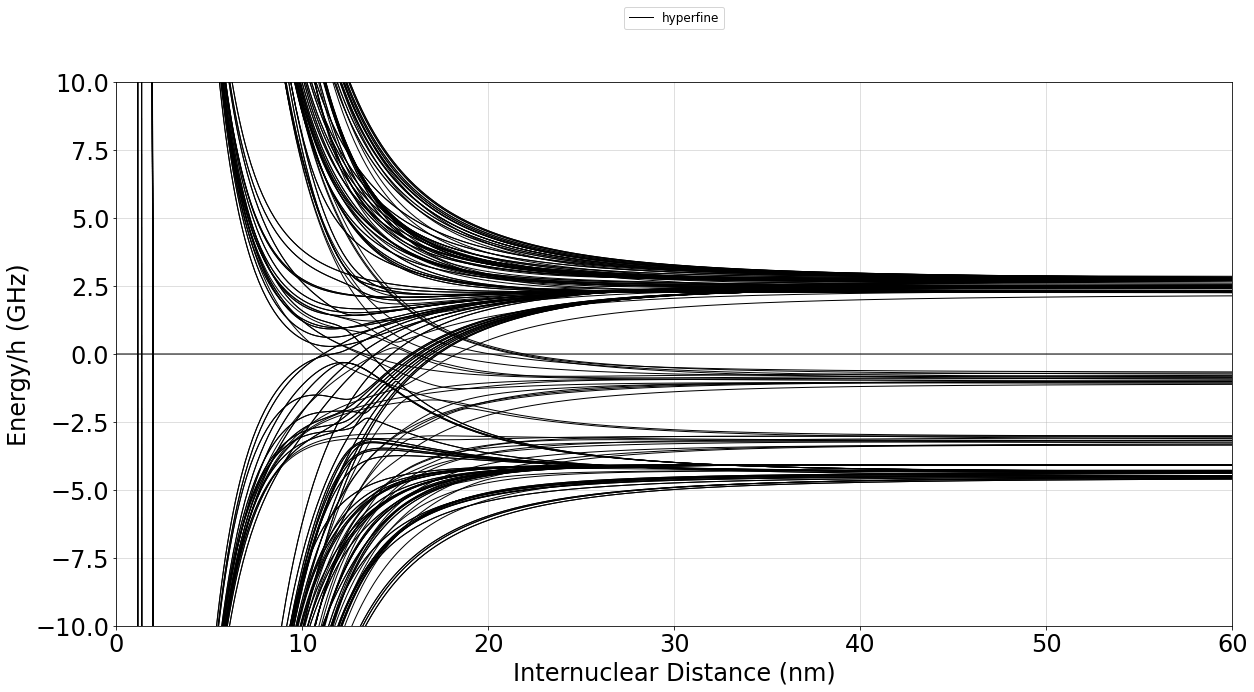

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
fs = 24

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,    -mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b','3a','3b','4a','4b','5a','5b']
# for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
which = 0
title, ylims, yoff = titles[which], allYlims[which], yoffsets[which]
for label in labels:
    color, linestyle = getLabelColorAndLinestyle(label)
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color='black', linestyle='-', linewidth=1, 
                label='hyperfine' if datanum==0 and label=='2b' else None)
leg = ax.legend(fontsize=12, ncol=7, loc='upper center', bbox_to_anchor=(0.5,1.15))
for text in leg.get_texts():
    text.set_color("k")

ax.tick_params(axis='both', which='major', labelsize=fs)

ax.axhline(0,color='k',alpha=0.5)
# ax.text(60,-1.4, title + "\nDissociation Limit", fontsize=fs, color='k')
# ax.set_ylim(*ylims)
# ax.set_xlim(min(Rvals)*1e9,40)
plt.xlim(00,60)
plt.ylim(-10,10)
ax.grid(alpha=0.5)
#if num != len(axs)-1 and num != len(axs)-2 and num != 0:
#    ax.set_xticklabels([]);
#elif num != 0:
ax.set_xlabel('Internuclear Distance (nm)', fontsize=fs)
ax.set_ylabel('Energy/h (GHz)', fontsize=fs)


# color = 'tab:cyan'
# linewidth = 3
# plt.plot(Rval*1e9,H1_e1,color = color,label = 'fine',linewidth=linewidth) #
# plt.plot(Rval*1e9,H1_e2, color = color,linewidth=linewidth)     #              
# plt.plot(Rval*1e9,H2_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H2_e2,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H3_e1,color = 'tab:blue',linewidth=linewidth) ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H3_e2,color = color,linewidth=linewidth)                     ### 0^g+ in Marks calc
# plt.plot(Rval*1e9,H4_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H4_e2,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H5_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H5_e2,color = color,linewidth=linewidth) #
# plt.plot(Rval*1e9,H5_e3,color = color,linewidth=linewidth) #
# plt.plot(Rval*1e9,H6_e1,color = color,linewidth=linewidth) #
# plt.plot(Rval*1e9,H6_e2,color = color,linewidth=linewidth) #
# plt.plot(Rval*1e9,H6_e3,color = color,linewidth=linewidth) 
# plt.plot(Rval*1e9,Htot7,color =  color,linewidth=linewidth) #
# plt.plot(Rval*1e9,Htot8,color = color,linewidth=linewidth)
# # plt.plot(Rval*1e9,Htot9,color = color, label = 'F states')
# # plt.plot(Rval*1e9,Htot10,color = color,linewidth=linewidth)
# plt.legend(loc='upper right',fontsize=16)
# # plt.margins(x=0)
# # from matplotlib.pyplot import figure
# # fig.savefig('FS.png', dpi=100)


#plt.savefig("D1_Zoomed_Out.svg", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

/var/folders/p1/sslzk5t517d2pwp06md4xf_w0000gn/T/ipykernel_21358/1097517479.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


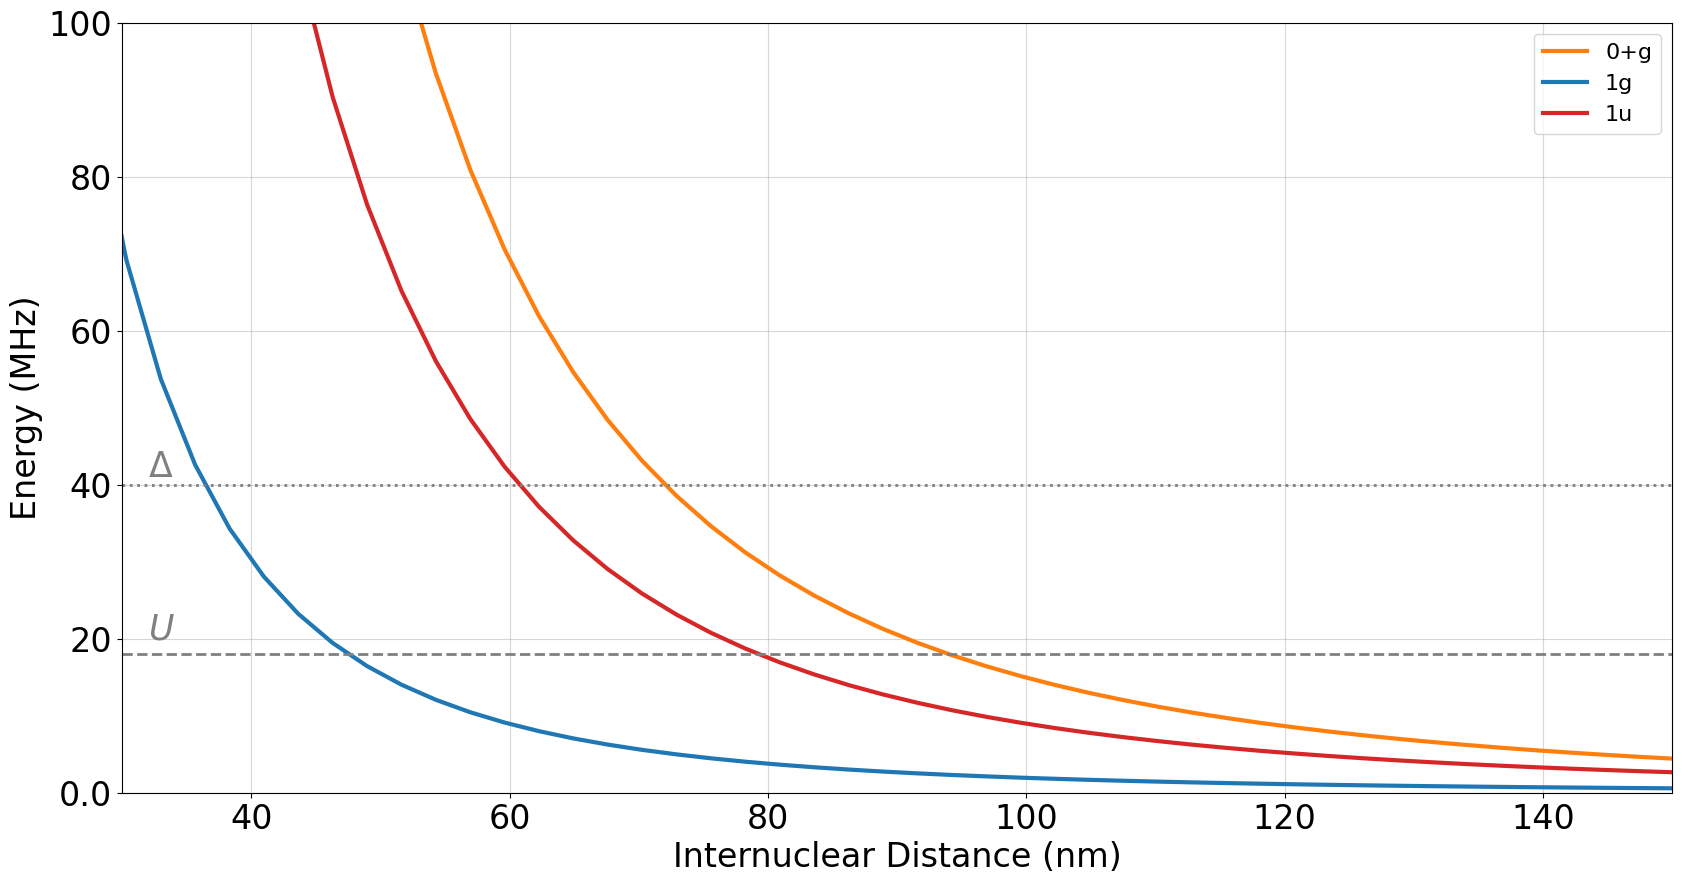

In [211]:
fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.xlim(30,150)
plt.ylim(-0,.1)
ax.grid(alpha=0.5)
#if num != len(axs)-1 and num != len(axs)-2 and num != 0:
#    ax.set_xticklabels([]);
#elif num != 0:
yticklabels = ['0.0','20','40','60','80','100']
ax.set_yticklabels(yticklabels)
ax.set_xlabel('Internuclear Distance (nm)', fontsize=fs)
ax.set_ylabel('Energy (MHz)', fontsize=fs)


color = 'tab:orange'
linewidth = 3
# plt.plot(Rval*1e9,H1_e1,color = color,label = 'fine',linewidth=linewidth) #
plt.plot(Rval*1e9,H1_e2, color = color,linewidth=linewidth, label = '0+g')     #              
# plt.plot(Rval*1e9,H2_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H2_e2,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H3_e1,color = 'tab:blue',linewidth=linewidth) 
# plt.plot(Rval*1e9,H3_e2,color = color,linewidth=linewidth)                     
# plt.plot(Rval*1e9,H4_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H4_e2,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H5_e1,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,H5_e2,color = color,linewidth=linewidth) #
plt.plot(Rval*1e9,H5_e3,color = 'tab:blue',linewidth=linewidth,label = '1g') #
# plt.plot(Rval*1e9,H6_e1,color = color,linewidth=linewidth) #
plt.plot(Rval*1e9,H6_e2,color = 'tab:red',linewidth=linewidth,label = '1u') #
# plt.plot(Rval*1e9,H6_e3,color = color,linewidth=linewidth) 
# plt.plot(Rval*1e9,Htot7,color =  color,linewidth=linewidth) #
# plt.plot(Rval*1e9,Htot8,color = color,linewidth=linewidth)
# plt.plot(Rval*1e9,Htot9,color = color, label = 'F states')
# plt.plot(Rval*1e9,Htot10,color = color,linewidth=linewidth)
plt.text(32,0.041,r'$\Delta$', fontsize=25, color='grey')
plt.text(32,0.02,r'$U$', fontsize=25, color='grey')
# plt.text(28,2.6,r'$\propto R^{-4}$', fontsize=25, color='black')
# plt.text(45,2.55,r'$\propto R^{-3.1}$', fontsize=25, color='black')
# plt.text(55,2.6,r'$\propto R^{-3}$', fontsize=25, color='black')
plt.axhline(y=.04,linestyle=':', color='grey')
plt.axhline(y=.018,linestyle='--', color='grey')
plt.legend(loc='upper right',fontsize=16)


I'm estimating the collisional distance in the model between 40 and 80 nm based off of the repulsive fine structure potentials and the collisional detuning that maximizes 2-1 events. Hyperfine and rotational interactions just increase the density of available states at these large distances, so I think this is a good estimate.

### relevant repulsive potentials:
1g,2g,1u,0+g

### fit repulsive potentials

0+g decay power: [16437.08      3.097]
1g decay power: [7216.449    4.064]
1u decay power: [8972.027    3.   ]


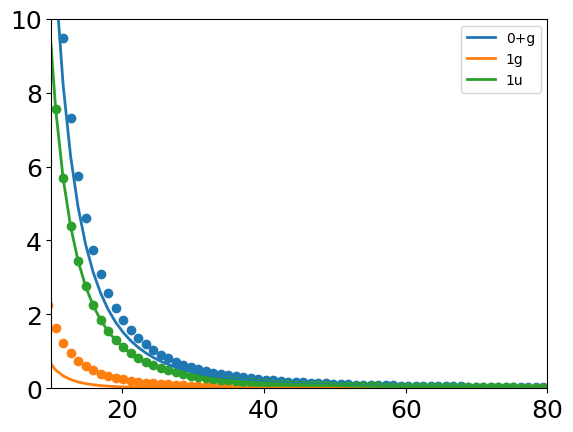

In [206]:
def decay(x, a, b):
    return a/x**b

# Generate some example data
x = Rval*1e9
zeroPlusG = H1_e2
oneG = H5_e3
oneU = H6_e2

# Fit the curve to the data
popt0G, pcov0G = curve_fit(decay, x, zeroPlusG)
popt1G, pcov1G = curve_fit(decay, x, oneG)
popt1U, pcov1U = curve_fit(decay, x, oneU)

# Extract the decay power
decay_power0G = popt0G
decay_power1G = popt1G
decay_power1U = popt1U

# Plot the results
plt.scatter(x, zeroPlusG)
plt.scatter(x, oneG)
plt.scatter(x, oneU)
plt.xlim(10,80)
plt.ylim(0,10)
plt.plot(x, decay(x, *popt0G), label='0+g')
plt.plot(x, decay(x, *popt1G), label='1g')
plt.plot(x, decay(x, *popt1U), label='1u')
# plt.xlabel('x')
# plt.ylabel('y')
plt.legend()
# plt.show()

print("0+g decay power:", decay_power0G)
print("1g decay power:", decay_power1G)
print("1u decay power:", decay_power1U)


Fitted parameters: [6970.009    1.   ]


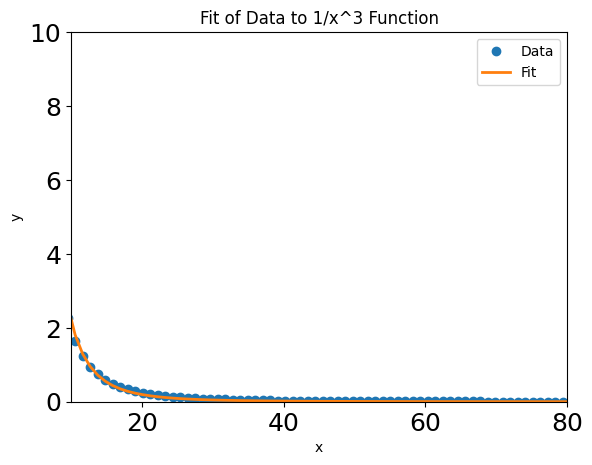

In [202]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(x, a):
    return a / x**3.5

# Generate some sample data
xdata = x
ydata = oneG

# Fit the data to the function
popt, pcov = curve_fit(func, xdata, ydata)

# Print the fitted parameters
print('Fitted parameters:', popt)

# Plot the data and the fitted function
plt.plot(xdata, ydata, 'o', label='Data')
plt.plot(xdata, func(xdata, *popt), '-', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit of Data to 1/x^3 Function')
plt.xlim(10,80)
plt.ylim(0,10)
plt.legend()
plt.show()


### Just HFS

In [29]:
def getLabelColorAndLinestyle(label):
    phiColors=['purple','blue','green', 'orange','red', '#FF69B4']       
    if label[0] == '0':
        if label[-1] == '1':
            color = 'black'
        elif label[-1] == '2':
            color = '#800080'
    else:
        color = phiColors[int(label[0])]
    linestyle = 'dashed' if label[1] == 'b' else 'solid'
    return color, linestyle

Text(0, 0.5, 'Energy/h (GHz)')

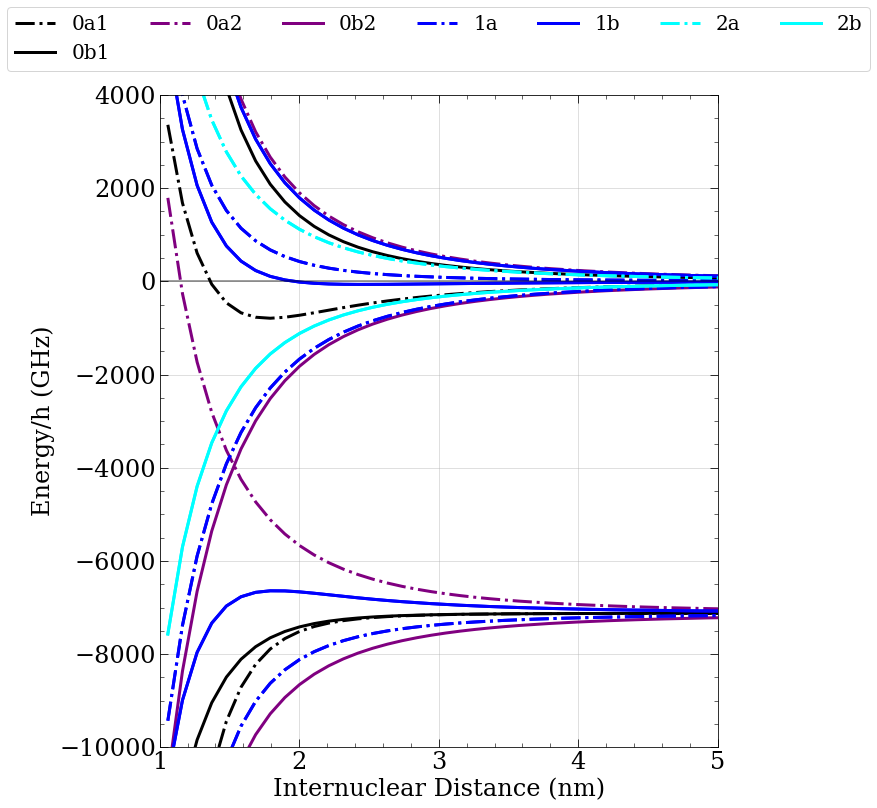

In [44]:
fig, ax = plt.subplots(figsize=(10,12))
fs = 24

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,    -mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b'] #,'3a','3b','4a','4b','5a','5b']
#for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
which = 0
title, ylims, yoff = titles[which], allYlims[which], yoffsets[which]
for label in labels:
    color, linestyle = getLabelColorAndLinestyle(label)
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=3, 
                label=label if datanum==0 else None)
leg = ax.legend(fontsize=20, ncol=7, loc='upper center', bbox_to_anchor=(0.5,1.15))
for text in leg.get_texts():
    text.set_color("k")

ax.tick_params(axis='both', which='major', labelsize=fs)

ax.axhline(0,color='k',alpha=0.5)
# ax.text(60,-1.4, title + "\nDissociation Limit", fontsize=fs, color='k')
ax.set_ylim(-10000,4000)
ax.set_xlim(1,5)
ax.grid(alpha=0.5)
#if num != len(axs)-1 and num != len(axs)-2 and num != 0:
#    ax.set_xticklabels([]);
#elif num != 0:
ax.set_xlabel('Internuclear Distance (nm)', fontsize=fs)
ax.set_ylabel('Energy/h (GHz)', fontsize=fs)
#plt.savefig("D1_Zoomed_Out.svg", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

(1.0, 50.0)

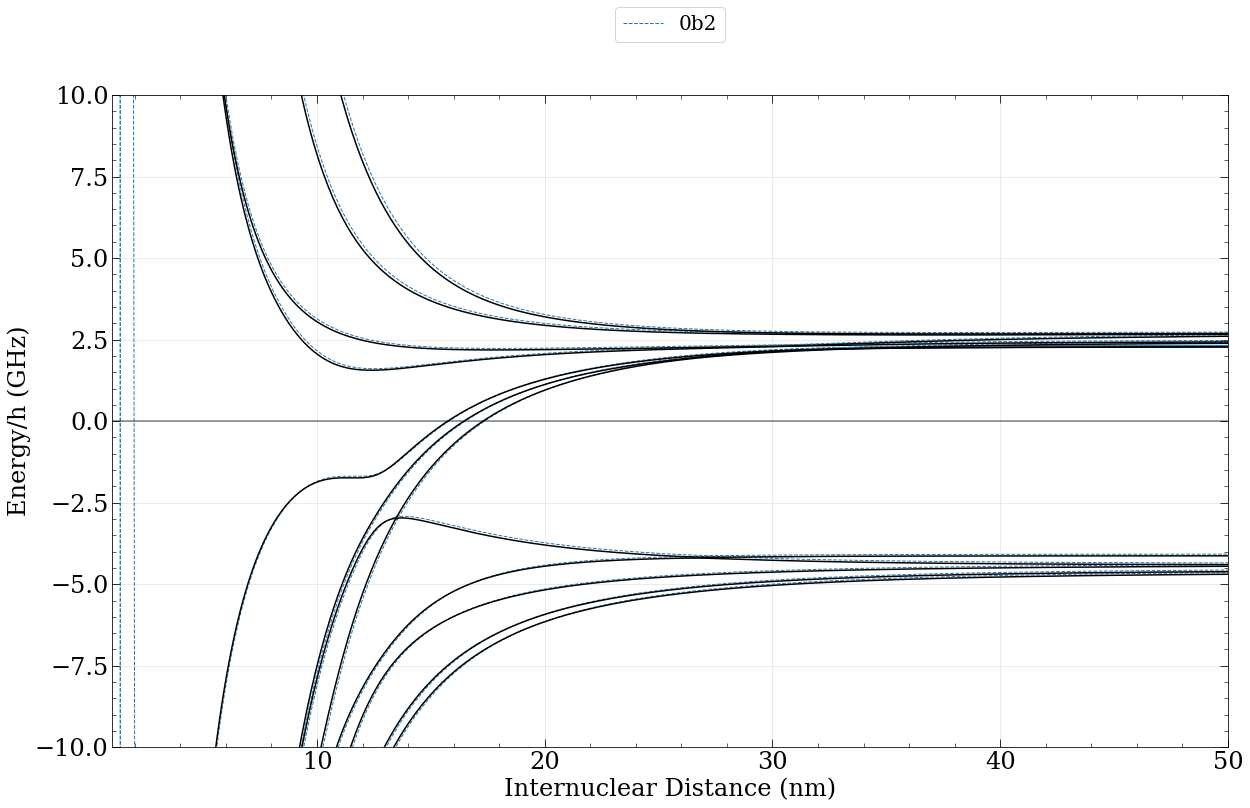

In [18]:
fig, ax = plt.subplots(figsize=(20,12))
fs = 24

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,    -mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b','3a','3b','4a','4b','5a','5b']
labels = ['0b2']
#for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
which = 0
title, ylims, yoff = titles[which], allYlims[which], yoffsets[which]
for label in labels:
    color, linestyle = getLabelColorAndLinestyle(label)
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h  , color='tab:blue', linestyle='--', linewidth=1, 
                label=label if datanum==0 else None)
leg = ax.legend(fontsize=20, ncol=7, loc='upper center', bbox_to_anchor=(0.5,1.15))
for text in leg.get_texts():
    text.set_color("k")

ax.tick_params(axis='both', which='major', labelsize=fs)

ax.axhline(0,color='k',alpha=0.5)
# ax.text(60,-1.4, title + "\nDissociation Limit", fontsize=fs, color='k')
# ax.set_ylim(*ylims)
ax.set_xlim(min(Rvals)*1e9,40)
ax.grid(alpha=0.5)
#if num != len(axs)-1 and num != len(axs)-2 and num != 0:
#    ax.set_xticklabels([]);
#elif num != 0:
ax.set_xlabel('Internuclear Distance (nm)', fontsize=fs)
ax.set_ylabel('Energy/h (GHz)', fontsize=fs)



import re

file_path = 'Pauls_potentials/PotSP_phi=0a-.dat'

# Initialize lists for values
with open(file_path, 'r') as file:
    for line in file:
        if re.match(r'^\s*\d+\.\d+', line):
            values = re.findall(r'[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?', line)
all_values = [[] for _ in range(len(values))]

# Read the file again to extract the data
with open(file_path, 'r') as file:
    for line in file:
        if re.match(r'^\s*\d+\.\d+', line):
            values = re.findall(r'[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?', line)
            if values:
                for i, value in enumerate(values):
                    if i == 0:
                        all_values[i].append(float(value) * 0.0529177)
                    else:
                        all_values[i].append(float(value) * 30-7128 )

for i, values in enumerate(all_values[1:]):
    plt.plot(all_values[0], values, label=f'Value {i+2}',color='k')

 
ax.grid(True,alpha=0.3)
ax.set_ylim(-10, 10)
ax.set_xlim(1,50)